# Case Study 6.1 - NYC Taxi Trips

# Identification Information

In [1]:
# YOUR NAME              = Qi Guo
# YOUR MITX PRO USERNAME = guoqi228
# YOUR MITX PRO E-MAIL   = guoqi228@gmail.com

# Setup

Run these cells to install all the packages you need to complete the remainder of the case study. This may take a few minutes, so please be patient.

In [2]:
!pip install featuretools==0.1.19

    100% |████████████████████████████████| 143kB 2.6MB/s ta 0:00:01
    100% |████████████████████████████████| 31.2MB 21kB/s eta 0:00:01    16% |█████▍                          | 5.3MB 3.8MB/s eta 0:00:07    27% |████████▉                       | 8.7MB 4.0MB/s eta 0:00:06    46% |██████████████▉                 | 14.4MB 2.6MB/s eta 0:00:07    52% |████████████████▉               | 16.4MB 2.1MB/s eta 0:00:08    78% |█████████████████████████       | 24.4MB 2.4MB/s eta 0:00:03    87% |████████████████████████████    | 27.3MB 2.5MB/s eta 0:00:02    90% |█████████████████████████████   | 28.2MB 3.8MB/s eta 0:00:01    92% |█████████████████████████████▌  | 28.7MB 2.4MB/s eta 0:00:02    94% |██████████████████████████████▍ | 29.6MB 4.9MB/s eta 0:00:01
  Running setup.py bdist_wheel for featuretools ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/2b/71/de/99b59608fad48046821e6c3a5585cd8797ee02e2c8e53e9d62
  Running setup.py bdist_wheel for s3fs ... done
  Stored in directory:

# Import

Import the required tools into the notebook.

In [3]:
import featuretools as ft
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import utils
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday,
                                     Weekend)
from sklearn.ensemble import GradientBoostingRegressor
from utils import (compute_features, feature_importances, load_nyc_taxi_data,
                   preview)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [4]:
%matplotlib inline

In [5]:
assert ft.__version__ == '0.1.19', 'Make sure you run the command above with the correct version.'

# Data

Load the NYC taxi trip data. Note that this may take a minute or two, so please be patient.

In [6]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I
5,514035,1,2016-04-02 00:01:00,2016-04-02 00:09:00,2,1.50,-73.981956,40.765518,-73.968124,40.753407,1,458,AR,N
6,514036,1,2016-04-02 00:01:00,2016-04-02 00:05:00,1,1.50,-73.980019,40.780594,-73.968132,40.799595,2,213,AV,U
7,514037,1,2016-04-02 00:01:00,2016-04-02 00:20:00,1,4.20,-73.990501,40.756561,-73.986008,40.719414,2,1142,AA,AC
8,514038,1,2016-04-02 00:01:00,2016-04-02 00:10:00,1,0.60,-73.986198,40.730492,-73.991798,40.722240,1,501,AT,AC
9,514039,1,2016-04-02 00:01:00,2016-04-02 00:17:00,1,0.60,-73.990959,40.734890,-74.001816,40.739319,1,954,R,Q


We can also plot some aspects of the data to get a better sense of its distributions. For instance, here is the `trip_duration` variable we are going to try to predict.

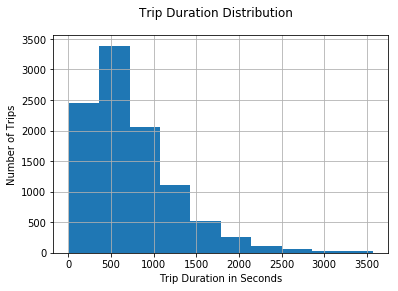

In [7]:
trips.trip_duration.hist()
plt.xlabel('Trip Duration in Seconds')
plt.ylabel('Number of Trips')
plt.suptitle('Trip Duration Distribution')
plt.show()

In [8]:
trips.shape[0]  # Tells us how many trips are in the dataset

10000

<h1 style="color:red;">QUESTION 1: DATA ANALYSIS</h1>

**Describe the dataset. How many trips are in the dataset? How would you describe the distribution of trip durations? Is there anything else we should observe? Make sure the histogram is visible in the notebook.**

*Type your response here...*
#### There are 10,000 trips in the dataset. The trip duration is mainly distributed between 0 and 1,000 seconds, which is about 70% of total trips. Trip duration around 500 seconds is more than 30% of total trips. When trip duration exceed 1500 seconds, the number become less and less. 

# Entities and Relationships

In [9]:
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

# Transform Primitives

In [10]:
trans_primitives = [Weekend]

# This may take some time to compute
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

Here are the features that we just created. Note: This list may contain the `trip_duration` variable. But, rest assured that we will not actually use this variable in training. Our code removes that variable in `utils.py`.

In [11]:
print(f"Number of features: {len(features)}")
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Finally, we compute the feature matrix from these features.

In [12]:
feature_matrix = compute_features(features, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 5)

Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,trip_distance,trip_duration,IS_WEEKEND(dropoff_datetime),dropoff_neighborhood = D,dropoff_neighborhood = AA,dropoff_neighborhood = H,dropoff_neighborhood = P,dropoff_neighborhood = AR,dropoff_neighborhood = AD,dropoff_neighborhood = A,...,pickup_neighborhood = AO,pickup_neighborhood = AD,pickup_neighborhood = Q,pickup_neighborhood = AR,pickup_neighborhood = AP,pickup_neighborhood = H,pickup_neighborhoods.latitude,IS_WEEKEND(pickup_datetime),dropoff_neighborhoods.latitude,vendor_id
id,,,,,,,,,,,,,,,,,,,,,
514030,2.46,1039,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.757707,True,40.766809,2
514031,7.90,1454,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.744928,True,40.793597,1
514032,1.00,1168,True,0,0,0,0,0,0,0,...,0,0,0,0,0,1,40.729652,True,40.740333,1
514033,0.02,35,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.720245,True,40.720245,2
514034,19.00,3470,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.646194,True,40.785005,1


# First Model

In [13]:
# Split data
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [14]:
# This should train within a minute or so
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test) # This is the R^2 value of the prediction

      Iter       Train Loss   Remaining Time 
         1           0.4736           10.76s
         2           0.4148           10.45s
         3           0.3661           10.18s
         4           0.3266           10.89s
         5           0.2934           10.33s
         6           0.2665           10.40s
         7           0.2441           10.35s
         8           0.2257           10.42s
         9           0.2103           10.10s
        10           0.1973           10.01s
        20           0.1434            8.64s
        30           0.1312            7.36s
        40           0.1248            5.87s
        50           0.1218            4.60s
        60           0.1191            3.59s
        70           0.1174            2.62s
        80           0.1158            1.72s
        90           0.1147            0.84s
       100           0.1137            0.00s


0.7527788676087426

<h1 style="color:red;">QUESTION 2: FIRST MODEL</h1>

**Describe the 2 new features that we added to the model. Do you think these improved the performance from a model that did not have these features? Why?**

*Type your response here...*
#### The 2 new features are : IS_WEEKEND(pickup_datetime) and IS_WEEKEND(dropoff_datetime). I think these two feature improved the performance. Because the trip duration in the weekend tend to be longer than weekdays. It's better to use this feature to make better prediction. 

# More Transform Primitives

In [15]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [16]:
print(f"Number of features: {len(features)}")
features

Number of features: 25


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [17]:
feature_matrix = compute_features(features, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 5)

Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,IS_WEEKEND(dropoff_datetime),dropoff_neighborhood = D,dropoff_neighborhood = AA,dropoff_neighborhood = H,dropoff_neighborhood = P,dropoff_neighborhood = AR,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AB,dropoff_neighborhood = AV,...,WEEK(pickup_datetime),trip_distance,MINUTE(pickup_datetime),HOUR(pickup_datetime),pickup_neighborhoods.latitude,payment_type,WEEKDAY(dropoff_datetime),passenger_count,WEEKDAY(pickup_datetime),DAY(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
514030,True,0,0,0,0,0,0,0,0,0,...,13,2.46,0,0,40.757707,1,5,1,5,2
514031,True,0,0,0,0,0,0,0,0,0,...,13,7.90,0,0,40.744928,1,5,2,5,2
514032,True,0,0,0,0,0,0,0,0,0,...,13,1.00,0,0,40.729652,1,5,1,5,2
514033,True,0,0,0,0,0,0,0,0,0,...,13,0.02,0,0,40.720245,2,5,1,5,2
514034,True,0,0,0,0,0,0,0,0,0,...,13,19.00,1,0,40.646194,1,5,2,5,2


In [18]:
# Re-split data
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [19]:
# This should train within a minute or so
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test) # This is the R^2 value of the prediction

      Iter       Train Loss   Remaining Time 
         1           0.4736           15.40s
         2           0.4148           16.26s
         3           0.3661           15.33s
         4           0.3264           15.03s
         5           0.2930           14.71s
         6           0.2660           14.20s
         7           0.2432           13.73s
         8           0.2245           13.43s
         9           0.2090           13.25s
        10           0.1960           12.95s
        20           0.1362           11.02s
        30           0.1200            9.45s
        40           0.1126            7.75s
        50           0.1079            6.25s
        60           0.1047            4.86s
        70           0.1016            3.66s
        80           0.0986            2.38s
        90           0.0938            1.16s
       100           0.0899            0.00s


0.8059573190397493

<h1 style="color:red;">QUESTION 3: SECOND MODEL</h1>

**Describe the rest of the new features that we just added to the model. How did this affect performance? Did we have to sacrifice training time?**

*Type your response here...*
#### There are a lot more features added to this model. For example, MINUTES, DAY, MONTH, WEEK, WEEKDAY. These new features improved the model performance. The R squre value is 0.81 which was 0.75 in previous model. There is no obvious difference in training time.

# Aggregation Primitives

In [20]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [21]:
print(f"Number of features: {len(features)}")
features

Number of features: 75


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.SUM(trips.vendor_id)>,
 <Fe

In [22]:
# This may take a bit longer to compute, so please be patient
feature_matrix = compute_features(features, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 5)

Elapsed: 00:08 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,IS_WEEKEND(dropoff_datetime),pickup_neighborhoods.MEDIAN(trips.trip_duration),pickup_neighborhoods.STD(trips.trip_distance),MONTH(pickup_datetime),dropoff_neighborhoods.STD(trips.trip_duration),WEEK(dropoff_datetime),pickup_neighborhoods.longitude,pickup_neighborhoods.MIN(trips.passenger_count),HOUR(pickup_datetime),payment_type,...,pickup_neighborhood = AO,pickup_neighborhood = AD,pickup_neighborhood = Q,pickup_neighborhood = AR,pickup_neighborhood = AP,pickup_neighborhood = H,vendor_id,pickup_neighborhoods.SUM(trips.vendor_id),DAY(dropoff_datetime),dropoff_neighborhoods.MAX(trips.trip_duration)
id,,,,,,,,,,,,,,,,,,,,,
514030,True,NaN,NaN,4,NaN,13,-73.986446,NaN,0,1,...,0,0,0,0,0,0,2,NaN,2,NaN
514031,True,NaN,NaN,4,NaN,13,-73.919159,NaN,0,1,...,0,0,0,0,0,0,1,NaN,2,NaN
514032,True,NaN,NaN,4,NaN,13,-73.991595,NaN,0,1,...,0,0,0,0,0,1,1,NaN,2,NaN
514033,True,NaN,NaN,4,NaN,13,-73.987205,NaN,0,2,...,0,0,0,0,0,0,2,NaN,2,NaN
514034,True,NaN,NaN,4,NaN,13,-73.785073,NaN,0,1,...,0,0,0,0,0,0,1,NaN,2,NaN


In [23]:
# Re-split data
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [24]:
# This should train within a minute or so
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test) # This is the R^2 value of the prediction

      Iter       Train Loss   Remaining Time 
         1           0.4736           13.81s
         2           0.4148           13.43s
         3           0.3661           13.21s
         4           0.3264           13.52s
         5           0.2930           13.21s
         6           0.2660           12.98s
         7           0.2432           12.97s
         8           0.2245           13.06s
         9           0.2090           12.96s
        10           0.1960           12.74s
        20           0.1362           10.72s
        30           0.1200            8.87s
        40           0.1126            7.17s
        50           0.1079            5.75s
        60           0.1047            4.47s
        70           0.1016            3.27s
        80           0.0986            2.13s
        90           0.0938            1.04s
       100           0.0899            0.00s


0.8060128240391375

# Evaluate on Test Data

In [25]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 # undo the log we took earlier

In [26]:
# Print the first 5 predictions
y_pred[:5]

array([453.4415368 , 666.8066337 , 634.00494622, 617.34019506,
       407.96332751])

(array([418., 739., 547., 301., 253., 100.,  61.,  40.,  29.,  12.]),
 array([  13.00778932,  284.36132154,  555.71485376,  827.06838598,
        1098.4219182 , 1369.77545042, 1641.12898264, 1912.48251486,
        2183.83604708, 2455.1895793 , 2726.54311152]),
 <a list of 10 Patch objects>)

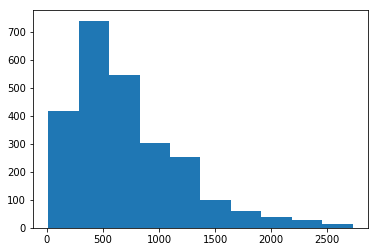

In [27]:
# Create a histogram of all of them
matplotlib.pyplot.hist(y_pred)

<h1 style="color:red;">QUESTION 4: MODEL PREDICTIONS</h1>

**Analyze the model predictions. Does the output distribution match the one you made earlier in the case study? What other features/strategies could we use to make our model even better, if we had more time?**

*Type your response here...*
#### The model prediction matches the original data. If we had more time, we need to further more select the features with more influence on the model, discard the features with little or no influence. 

# Feature Importance

In [28]:
feature_importances(model, feature_matrix.columns, n=25)

1: Feature: pickup_neighborhoods.MAX(trips.passenger_count), 0.325
2: Feature: dropoff_neighborhoods.STD(trips.trip_duration), 0.107
3: Feature: HOUR(pickup_datetime), 0.105
4: Feature: MINUTE(dropoff_datetime), 0.085
5: Feature: dropoff_neighborhoods.MEAN(trips.passenger_count), 0.070
6: Feature: pickup_neighborhoods.longitude, 0.069
7: Feature: MONTH(pickup_datetime), 0.062
8: Feature: payment_type, 0.060
9: Feature: dropoff_neighborhoods.MEDIAN(trips.vendor_id), 0.029
10: Feature: WEEK(dropoff_datetime), 0.012
11: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.012
12: Feature: IS_WEEKEND(pickup_datetime), 0.009
13: Feature: pickup_neighborhoods.MIN(trips.trip_distance), 0.009
14: Feature: dropoff_neighborhoods.STD(trips.passenger_count), 0.007
15: Feature: dropoff_neighborhoods.MEAN(trips.trip_distance), 0.006
16: Feature: dropoff_neighborhoods.MEDIAN(trips.trip_distance), 0.005
17: Feature: dropoff_neighborhood = AA, 0.004
18: Feature: dropoff_neighborhoods.MAX(trips.ven

<h1 style="color:red;">QUESTION 5: FEATURE IMPORTANCE</h1>

**Analyze the feature importance values you just computed above. Do they make sense? Are there any values you are surprised by? Give some brief explanations as to why these features are relevant in computing the `trip_duration` target variable.**

*Type your response here...*
#### It makes sense. It's surprise that MONTH is has a relative high influence. It is easy to understand that the trip duration is dominated by the pick up and drop off location. Because taxi tend to pick up more people in cetain area, such as comerical district. Also, the pick up hour has more inflence because most of trips happen during the rush hours of the day. 

<hr>

Great job! Now, make sure you check out the **Conclusion** section of the [instruction manual](https://courses.edx.org/asset-v1:MITxPRO+DSx+2T2018+type@asset+block@6.1_instruction_manual.html) to wrap up this case study properly.